# Suppressing instability on a Vlasov-Poisson system with an external electric field
## Example: Two stream distribution

$$\mu(v) = \frac{1}{2\sqrt{2\pi}} \left(
    \exp\left(-\frac{(v - \bar{v})^2}{2}\right)
    + \exp\left(-\frac{(v + \bar{v})^2}{2}\right)
\right). 
$$

$$f(0, x, v) = (1 +\varepsilon\, \cos(\beta x)) \,\mu(v).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp

import optax

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver
from Utils.utils import plot_feq_distribution, plot_distribution

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())

[CudaDevice(id=0)]


## Problem setup and forward solver setup

In [2]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
t_values = jnp.linspace(0, t_final, int(t_final / dt))
L = 10 * jnp.pi
LV = 6.0

In [3]:
mesh = make_mesh(L, LV, nx, nv)


mu1 = 2.4
f_eq = (jnp.exp(-0.5*(mesh.V - mu1)**2) + jnp.exp(-0.5*(mesh.V + mu1)**2))/(2*jnp.sqrt(2*jnp.pi))
epsilon1 = 0.001 # Value to change
epsilon2 = 0.0 # Value to change
k_0 = 0.2
f_iv = (1 + epsilon1 * jnp.cos(k_0 * mesh.X) + epsilon2 * jnp.sin(k_0 * mesh.X)) * f_eq

In [4]:
# Function to compute the external field H (not time-dependent)
def compute_external_field(ak, mesh):
    k = jnp.arange(1, len(ak[0,:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[0,:] @ jnp.cos(k[:, None] * k_0 * mesh.xs) \
            + ak[1,:] @ jnp.sin(k[:, None] * k_0 * mesh.xs)  # Vectorized computation
    return H

def compute_external_field_sin(ak, mesh):
    k = jnp.arange(1, len(ak[:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[:] @ jnp.sin(k[:, None] * k_0 * mesh.xs)  # Vectorized computation
    return H

In [5]:
solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [6]:
# External field parameters (coefficients for the cosine terms)
k_total = 2
ak1 = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)

# Compute the external field
H1 = compute_external_field_sin(ak1, mesh)

In [7]:
f_array1, E_array1, ee_array1 = solver_jit(f_iv, 0.0*H1, t_final=t_final)

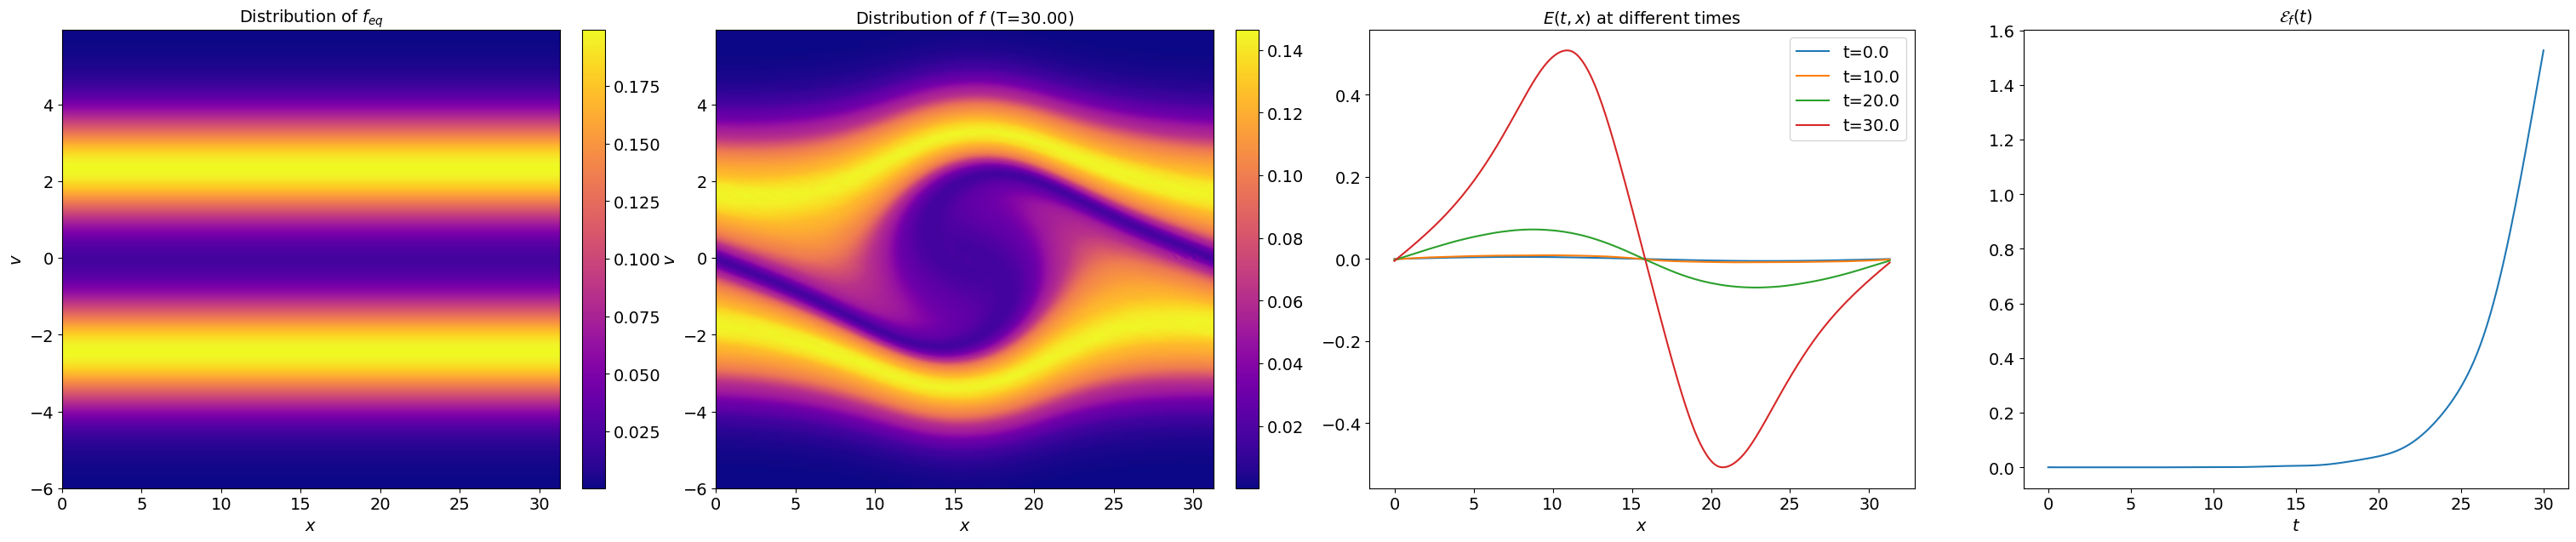

In [8]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))


plot_feq_distribution(fig, axs[0], f_eq, 'Distribution of $f_{eq}$', mesh)

plot_distribution(fig, axs[1], f_array1, 'Distribution of $f$', t_final, mesh)

axs[2].plot(mesh.xs, E_array1[0], label=f't={0*dt:.1f}')
axs[2].plot(mesh.xs, E_array1[99], label=f't={100*dt:.1f}')
axs[2].plot(mesh.xs, E_array1[199], label=f't={200*dt:.1f}')
axs[2].plot(mesh.xs, E_array1[299], label=f't={300*dt:.1f}')
axs[2].set_xlabel('$x$')
axs[2].set_title('$E(t,x)$ at different times')
axs[2].legend()

axs[3].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[3].plot(t_values, ee_array1)
axs[3].set_xlabel('$t$')
axs[3].set_title('$\\mathcal{E}_{f}(t)$')

plt.show()

## Optimization: finding the coefficients of the external electric field to suppress instability

### $L^{2}$ objecive function

In [ ]:
# Optimization through auto-differentiation with fixed basis.

# Adjust the J function to use f_final
def L2(f_final, solver):
    return jnp.sum((f_final - solver.f_eq) ** 2) * solver.mesh.dx * solver.mesh.dv

@jax.jit
def cost_function_L2(a_k):
    H = compute_external_field(a_k, mesh)
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    cost = L2(f_array, solver)
    return cost

#### Gradient Descent w/ Linesearch

In [ ]:
maxiter = 8000

solver_opt = optax.chain(
   optax.sgd(learning_rate=1.),
    optax.scale_by_zoom_linesearch(max_linesearch_steps=50)
)

def scan_fn(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_L2)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_L2(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)

opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_L2))

# Run the optimization and collect objective values using `scan`
res_opt_l2_1, objective_values_l2_1 = jax.lax.scan(scan_fn, (ak_init_1, opt_state), None, length=maxiter)


ak_opt_l2_1, state = res_opt_l2_1

In [ ]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_l2_1 = compute_external_field(ak_opt_l2_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_l2_1, t_final)

f_final1 = ff_array1

In [ ]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))


plot_distribution(fig, axs[0], f_final1, 'Distribution of $f[H]$', t_final, mesh)

#plot_distribution(fig, axs[0,1], jnp.abs(f_final1 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)

axs[1].plot(mesh.xs, H_l2_1, label='$H(x)$')
axs[1].plot(mesh.xs, E_array1[0] - H_l2_1, label=f'$E(t={0*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[99] - H_l2_1, label=f'$E(t={100*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[199] - H_l2_1, label=f'$E(t={200*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[299] - H_l2_1, label=f'$E(t={300*dt:.0f},x)$')
axs[1].set_xlabel('$x$')
axs[1].set_title('Electric fields')
axs[1].legend(loc='upper right')

#axs[2].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[2].plot(t_values, ee_array1)
axs[2].set_xlabel('$t$')
#axs[2].set_ylabel('Electric Energy')
axs[2].set_title('$\\mathcal{E}_{f}(t)$')


#axs[3].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[3].plot(objective_values_l2_1, label='L-BFGS')
#axs[3].set_yscale('log')
axs[3].set_xlabel("Iteration")
#axs[3].set_ylabel("Objective value")
axs[3].set_title("Convergence of Objective")


plt.show()

#### Gradient Descent

In [ ]:
maxiter = 8000
learning_rate = 1e-8
solver_opt = optax.sgd(learning_rate=learning_rate)

def scan_fn_gd(carry, _):
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_L2(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.01, maxval=0.01)

opt_state = solver_opt.init(ak_init_2)
grad = jax.jit(jax.grad(cost_function_L2))

# Run the optimization and collect objective values using `scan`
res_opt_l2_2, objective_values_l2_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)


ak_opt_l2_2, state = res_opt_l2_2

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_l2_2 = compute_external_field(ak_opt_l2_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_l2_2, t_final)

f_final2 = ff_array2

error_l2_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

In [ ]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_distribution(fig, axs[0], f_final2, 'Distribution of $f[H]$', t_final, mesh)

#plot_distribution(fig, axs[1], jnp.abs(f_final2 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[1].plot(mesh.xs, H_l2_2, label='$H(x)$')
axs[1].plot(mesh.xs, E_array2[0] - H_l2_2, label=f'$E(t={0*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array2[99] - H_l2_2, label=f'$E(t={100*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array2[199] - H_l2_2, label=f'$E(t={200*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array2[299] - H_l2_2, label=f'$E(t={300*dt:.0f},x)$')
axs[1].set_xlabel('$x$')
axs[1].set_title('Electric fields')
axs[1].legend(loc='upper right')



#axs[2].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[2].plot(t_values, ee_array2)
axs[2].set_xlabel('$t$')
axs[2].set_title('$\\mathcal{E}_{f}(t)$')


#axs[3].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[3].plot(objective_values_l2_2, label='GD')
#axs[3].set_yscale('log')
axs[3].set_xlabel("Iteration")
axs[3].set_title("Convergence of Objective")


plt.show()

### $KL$ objective function

In [ ]:
# Optimization through auto-differentiation with fixed basis.

def kl_divergence(f_final, solver, eps=1e-12):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = solver.f_eq / (jnp.sum(solver.f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(jax.scipy.special.rel_entr(f_final, f_eq + eps) * solver.mesh.dx * solver.mesh.dv)
    return kl_div

@jax.jit
def cost_function_kl(a_k):
    H = compute_external_field_sin(a_k, mesh)
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    cost = kl_divergence(f_array, solver)
    return cost


#### Gradient Descent w/ Linesearch

In [ ]:
maxiter = 8000

solver_opt = optax.chain(
   optax.sgd(learning_rate=1.),
    optax.scale_by_zoom_linesearch(max_linesearch_steps=50)
)

def scan_fn(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_kl)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_kl))


# Run the optimization and collect objective values using `scan`
res_opt_kl_1, objective_values_kl_1 = jax.lax.scan(scan_fn, (ak_init_1, opt_state), None, length=maxiter)


ak_opt_kl_1, state = res_opt_kl_1

In [ ]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_kl_1 = compute_external_field(ak_opt_kl_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)

f_final1 = ff_array1

error_kl_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

In [ ]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_distribution(fig, axs[0], f_final1, 'Distribution of $f[H]$', t_final, mesh)

#plot_distribution(fig, axs[1], jnp.abs(f_final1 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[1].plot(mesh.xs, H_kl_1, label='$H(x)$')
axs[1].plot(mesh.xs, E_array1[0] - H_kl_1, label=f'$E(t={0*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[99] - H_kl_1, label=f'$E(t={100*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[199] - H_kl_1, label=f'$E(t={200*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[299] - H_kl_1, label=f'$E(t={300*dt:.0f},x)$')
axs[1].set_xlabel('$x$')
axs[1].set_title('Electric fields')
axs[1].legend(loc='upper right')



#axs[2].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[2].plot(t_values, ee_array1)
axs[2].set_xlabel('$t$')
axs[2].set_title('$\\mathcal{E}_{f}(t)$')


#axs[3].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[3].plot(objective_values_kl_1, label='L-BFGS')
#axs[3].set_yscale('log')
axs[3].set_xlabel("Iteration")
axs[3].set_title("Convergence of Objective")


plt.show()

#### Gradient Descent

In [ ]:
maxiter = 8000
learning_rate = 1e-8
solver_opt = optax.sgd(learning_rate=learning_rate)

def scan_fn_gd(carry, _):
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_kl(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.01, maxval=0.01)

opt_state = solver_opt.init(ak_init_2)
grad = jax.jit(jax.grad(cost_function_kl))

# Run the optimization and collect objective values using `scan`
res_opt_kl_2, objective_values_kl_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)


ak_opt_kl_2, state = res_opt_kl_2

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_kl_2 = compute_external_field(ak_opt_kl_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final2 = ff_array2

error_kl_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

In [ ]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_distribution(fig, axs[0], f_final2, 'Distribution of $f[H]$', t_final, mesh)

#plot_distribution(fig, axs[1], jnp.abs(f_final2 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[1].plot(mesh.xs, H_kl_2, label='$H(x)$')
axs[1].plot(mesh.xs, E_array2[0] - H_kl_2, label=f'$E(t={0*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array2[99] - H_kl_2, label=f'$E(t={100*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array2[199] - H_kl_2, label=f'$E(t={200*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array2[299] - H_kl_2, label=f'$E(t={300*dt:.0f},x)$')
axs[1].set_xlabel('$x$')
axs[1].set_title('Electric fields')
axs[1].legend(loc='upper right')



#axs[2].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[2].plot(t_values, ee_array2)
axs[2].set_xlabel('$t$')
axs[2].set_title('$\\mathcal{E}_{f}(t)$')


#axs[3].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[3].plot(objective_values_kl_2, label='GD')
#axs[3].set_yscale('log')
axs[3].set_xlabel("Iteration")
axs[3].set_title("Convergence of Objective")


plt.show()

### Electric energy objective function

In [ ]:
# Optimization through auto-differentiation with fixed basis.

def electric_energy_opt(ee_array, solver):
    return jnp.sum(ee_array)*solver.dt

@jax.jit
def cost_function_ee(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = electric_energy_opt(ee_array, solver)
    return cost

#### Gradient Descent w/ Linesearch

In [ ]:
maxiter = 8000

solver_opt = optax.chain(
   optax.sgd(learning_rate=1.),
    optax.scale_by_zoom_linesearch(max_linesearch_steps=50)
)

def scan_fn(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_function_ee)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_ee(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)

opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_function_ee))


# Run the optimization and collect objective values using `scan`
res_opt_ee_1, objective_values_ee_1 = jax.lax.scan(scan_fn, (ak_init_1, opt_state), None, length=maxiter)


ak_opt_ee_1, state = res_opt_ee_1

In [ ]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_ee_1 = compute_external_field(ak_opt_ee_1, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_ee_1, t_final)

f_final1 = ff_array1

error_ee_1 = jnp.sum((f_final1 - f_eq)**2) * mesh.dx * mesh.dv

In [ ]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_distribution(fig, axs[0], f_final1, 'Distribution of $f[H]$', t_final, mesh)

#plot_distribution(fig, axs[1], jnp.abs(f_final1 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[1].plot(mesh.xs, H_ee_1, label='$H(x)$')
axs[1].plot(mesh.xs, E_array1[0] - H_ee_1, label=f'$E(t={0*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[99] - H_ee_1, label=f'$E(t={100*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[199] - H_ee_1, label=f'$E(t={200*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[299] - H_ee_1, label=f'$E(t={300*dt:.0f},x)$')
axs[1].set_xlabel('$x$')
axs[1].set_title('Electric fields')
axs[1].legend(loc='upper right')



#axs[2].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[2].plot(t_values, ee_array1)
axs[2].set_xlabel('$t$')
axs[2].set_title('$\\mathcal{E}_{f}(t)$')


#axs[3].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[3].plot(objective_values_ee_1, label='L-BFGS')
#axs[3].set_yscale('log')
axs[3].set_xlabel("Iteration")
axs[3].set_title("Convergence of Objective")


plt.show()

#### Gradient Descent

In [ ]:
maxiter = 8000
learning_rate = 1e-8
solver_opt = optax.sgd(learning_rate=learning_rate)

def scan_fn_gd(carry, _):
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
    obj_value = cost_function_ee(params)
    return (params, opt_state), obj_value

In [ ]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.01, maxval=0.01)

opt_state = solver_opt.init(ak_init_2)
grad = jax.jit(jax.grad(cost_function_ee))

# Run the optimization and collect objective values using `scan`
res_opt_ee_2, objective_values_ee_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)


ak_opt_ee_2, state = res_opt_ee_2

In [ ]:
H_init_2 = compute_external_field(ak_init_2, mesh)
H_ee_2 = compute_external_field(ak_opt_ee_2, mesh)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_ee_2, t_final)

f_final2 = ff_array2

error_ee_2 = jnp.sum((f_final2 - f_eq)**2) * mesh.dx * mesh.dv

In [ ]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_distribution(fig, axs[0], f_final2, 'Distribution of $f[H]$', t_final, mesh)

#plot_distribution(fig, axs[1], jnp.abs(f_final2 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[1].plot(mesh.xs, H_ee_1, label='$H(x)$')
axs[1].plot(mesh.xs, E_array1[0] - H_ee_1, label=f'$E(t={0*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[99] - H_ee_1, label=f'$E(t={100*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[199] - H_ee_1, label=f'$E(t={200*dt:.0f},x)$')
axs[1].plot(mesh.xs, E_array1[299] - H_ee_1, label=f'$E(t={300*dt:.0f},x)$')
axs[1].set_xlabel('$x$')
axs[1].set_title('Electric fields')
axs[1].legend(loc='upper right')



#axs[2].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[2].plot(t_values, ee_array1)
axs[2].set_xlabel('$t$')
axs[2].set_title('$\\mathcal{E}_{f}(t)$')


#axs[3].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[3].plot(objective_values_ee_1, label='L-BFGS')
#axs[3].set_yscale('log')
axs[3].set_xlabel("Iteration")
axs[3].set_title("Convergence of Objective")


plt.show()

### Comparing objective functions

In [ ]:
fig, axs = plt.subplots(1,2 ,figsize=(24, 7))


axs[0].plot(objective_values_kl_1, label='KL')
axs[0].plot(objective_values_l2_1, label='$L^2$')
axs[1].plot(objective_values_ee_1, label='$\\mathcal{E}_{f}$')
axs[0].set_yscale('log')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Objective value")
axs[0].set_title("Convergence using L-BFGS")
axs[0].legend()

axs[1].plot(objective_values_kl_2, label='KL')
axs[1].plot(objective_values_l2_2, label='$L^2$')
axs[1].plot(objective_values_ee_2, label='$\\mathcal{E}_{f}$')
axs[1].set_yscale('log')
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Objective value")
axs[1].set_title("Convergence using GD")
axs[1].legend()
plt.show()